<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

<H3 align='center'> Fernanda Urrea, ROL: 201551522-0 </H3>
<H3 align='center'> Matías Gómez, ROL: 201460501-3 </H3>

<hr style="height:2px;border:none"/>

## 4. CNN *vs* RNN Prediciendo el Ozono Atmosférico

En esta actividad utilizaremos redes neuronales para predicción de series de tiempo. Dada una serie de registros del valor de una variable en el tiempo (serie de tiempo) nos interesa entrenar un modelo que pueda predecir los valores futuros de la misma serie. 

En este caso, la serie corresponde a las concentraciones diarias (máximas) de $O_3$ medidas en la comuna de Las Condes entre Diciembre de 2003 y Diciembre de 2016. El $O_3$ (a nivel respirable) es un contaminante con graves efectos sobre la salud humana y sobre la agricultura, por lo que monitorear y predecir sus concentraciones en el tiempo es de gran relevancia. Se sabe que el $O_3$ alcanza sus niveles máximos en verano, por lo que estudiaremos sólo esos períodos. Esto hace que la serie que usted recibirá no es totalmente continua en el tiempo en el sentido de que los registros se miden hasta marzo de un año y se reinician en noviembre de ese mismo año. **Por favor considere atentamente esta situación.**   

El archivo *CSV* que usted recibirá tiene las siguientes columnas 

[‘registered_on’, ‘CO', 'PM10', 'PM25', 'NO', 'NOX', 'WD', 'RH', 'TEMP', 'WS', 'UVA', 'UVB', 'O3']

El primero corresponde a la fecha del registro. La última columna corresponde a la variable que queremos predecir y las demás son mediciones de otros contaminantes y de variables meteorológicas que podrían ayudar a predecir los niveles de $O_3$.  

Su tarea consistirá en entrenar una red capaz de predecir los niveles de ozono el día de mañana sólo partir de los niveles *previas* de ozono y demás variables. Para ésto pre-procesaremos los datos, cada contaminante tendrá su serie de tiempo y asociada con las otras. Con ésto deberemos generar *secuencias de entrenamiento*, recordar que cada secuencia estará asocaida a un *Target* que es el $O_3$ del día siguiente.

Compararemos y aplicaremos redes convolucionales uni-dimensionales y redes neuronales recurrentes, las cuales se adaptan perfectamente a escenarios de secuencias ya que modelan que el estado actual se genera a partir del estado anterior (como en una cadena de Markov).

---

En primer lugar carge el *csv* en un dataframe de pandas 

#### a) Explore los datos y visualícelos, ya sea a través de medidas de tendencia o gráficos. Lo primero que deberá realizar será crear su conjunto de validación/test a partir de los datos, por ejemplo las últimas mediciones puesto que la tarea será predecir los datos futuros (*out of box*). Además escale los datos apropiadamente.

#### Solo con input: Ozono (1-D)
Considere para construir las secuencias de entrenamiento sólo la información previa del $O_3$

In [427]:
import pandas  as pd
import numpy as np
df = pd.read_csv("./ozone_data.csv")

In [317]:
df.head()

,registered_on,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
0,2003-12-14,0.172413,0.094241,0.052434,0.016015,0.033293,0.643926,0.670000,0.415679,0.156788,0.035060,0.036334,0.359281
1,2003-12-15,0.241378,0.160995,0.119850,0.084537,0.111707,0.618166,0.822219,0.501561,0.155087,0.034838,0.036579,0.359281
2,2003-12-16,0.344828,0.227749,0.123596,0.118929,0.174259,0.626491,0.504444,0.694880,0.149334,0.033797,0.038170,0.544910
3,2003-12-17,0.275862,0.166230,0.138577,0.103177,0.170368,0.649371,0.503333,0.734857,0.167239,0.027892,0.026847,0.586826
4,2003-12-18,0.344828,0.172775,0.183521,0.119716,0.182938,0.624373,0.654444,0.611180,0.175061,0.032705,0.034957,0.610778


In [318]:
len(df)

1629

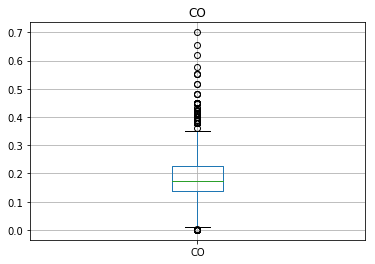

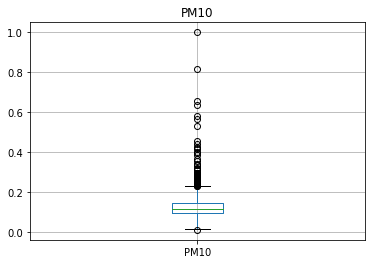

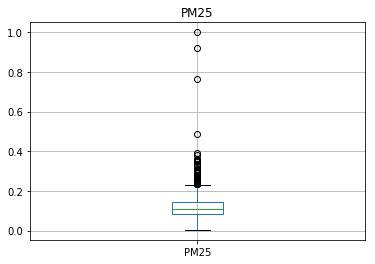

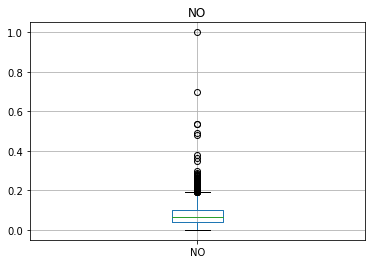

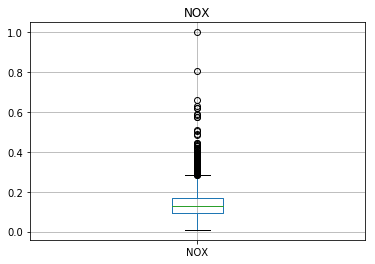

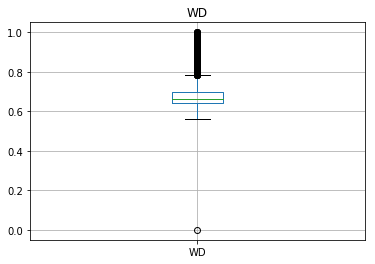

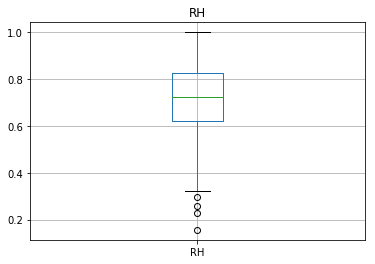

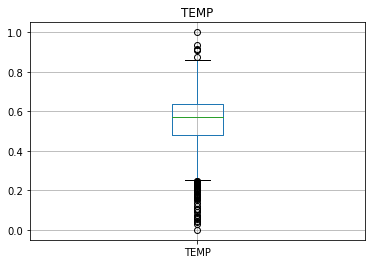

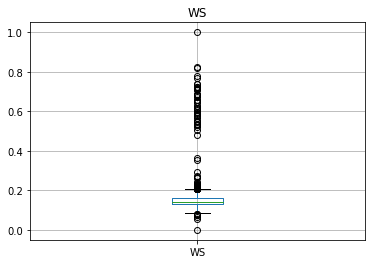

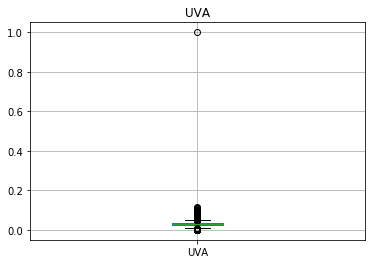

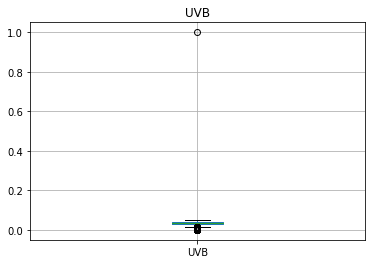

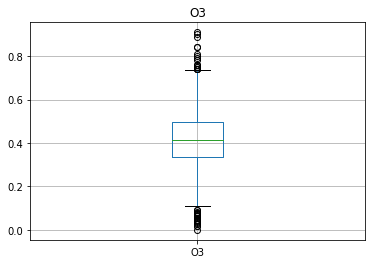

In [319]:
import matplotlib.pyplot as plt
df[["CO"]].boxplot()
plt.title("CO")
plt.show()
df[["PM10"]].boxplot()
plt.title("PM10")
plt.show()
df[["PM25"]].boxplot()
plt.title("PM25")
plt.show()
df[["NO"]].boxplot()
plt.title("NO")
plt.show()
df[["NOX"]].boxplot()
plt.title("NOX")
plt.show()
df[["WD"]].boxplot()
plt.title("WD")
plt.show()
df[["RH"]].boxplot()
plt.title("RH")
plt.show()
df[["TEMP"]].boxplot()
plt.title("TEMP")
plt.show()
df[["WS"]].boxplot()
plt.title("WS")
plt.show()
df[["UVA"]].boxplot()
plt.title("UVA")
plt.show()
df[["UVB"]].boxplot()
plt.title("UVB")
plt.show()
df[["O3"]].boxplot()
plt.title("O3")
plt.show()

In [320]:
df.describe()

,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
count,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,0.185423,0.129600,0.118716,0.078096,0.143159,0.688165,0.715321,0.552156,0.158919,0.032180,0.033077,0.415092
std,0.084199,0.064871,0.062701,0.062492,0.085842,0.082069,0.140079,0.132291,0.090008,0.031261,0.025226,0.127287
min,0.000000,0.011780,0.003745,0.000147,0.008587,0.000000,0.155555,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.137931,0.094241,0.082397,0.039211,0.091954,0.643123,0.618888,0.482512,0.128617,0.023690,0.028463,0.335329
50%,0.172413,0.117801,0.108614,0.067740,0.130622,0.663091,0.724444,0.569956,0.143259,0.030190,0.034660,0.413174
75%,0.226612,0.148560,0.142322,0.099501,0.169170,0.698589,0.824444,0.636792,0.159043,0.034680,0.037717,0.496634
max,0.700110,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.910180


In [321]:
atributos=list(df)
atributos=atributos[2:]

Detectamos y eliminamos los outliers.  

In [322]:
for atributo in atributos:
    print(atributo,": menores a 0.01 ",df[df[atributo]<0.01][atributo].count(), " mayores a 0.99 ",df[df[atributo]>0.99][atributo].count())

PM10 : menores a 0.01  0  mayores a 0.99  1
PM25 : menores a 0.01  2  mayores a 0.99  1
NO : menores a 0.01  54  mayores a 0.99  1
NOX : menores a 0.01  1  mayores a 0.99  1
WD : menores a 0.01  1  mayores a 0.99  13
RH : menores a 0.01  0  mayores a 0.99  4
TEMP : menores a 0.01  1  mayores a 0.99  1
WS : menores a 0.01  1  mayores a 0.99  1
UVA : menores a 0.01  222  mayores a 0.99  1
UVB : menores a 0.01  36  mayores a 0.99  1
O3 : menores a 0.01  1  mayores a 0.99  0


In [323]:
df=df[df['PM25']>0.01]
df=df[df['NOX']>0.01]
df=df[df['WD']>0.01]
df=df[df['TEMP']>0.01]
df=df[df['WS']>0.01]
df=df[df['O3']>0.01]
df=df[df['PM10']<0.99]
df=df[df['PM25']<0.99]
df=df[df['NO']<0.99]
df=df[df['TEMP']<0.99]
df=df[df['WS']<0.99]
df=df[df['UVA']<0.99]
df=df[df['UVB']<0.99]

In [324]:
for atributo in atributos:
    print(atributo,": menores a 0.01 ",df[df[atributo]<0.01][atributo].count(), " mayores a 0.99 ",df[df[atributo]>0.99][atributo].count())

PM10 : menores a 0.01  0  mayores a 0.99  0
PM25 : menores a 0.01  0  mayores a 0.99  0
NO : menores a 0.01  53  mayores a 0.99  0
NOX : menores a 0.01  0  mayores a 0.99  0
WD : menores a 0.01  0  mayores a 0.99  13
RH : menores a 0.01  0  mayores a 0.99  4
TEMP : menores a 0.01  0  mayores a 0.99  0
WS : menores a 0.01  0  mayores a 0.99  0
UVA : menores a 0.01  216  mayores a 0.99  0
UVB : menores a 0.01  32  mayores a 0.99  0
O3 : menores a 0.01  0  mayores a 0.99  0


In [325]:
len(df)

1616

In [326]:
df.describe()

,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
count,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000,1616.000000
mean,0.184971,0.128958,0.118240,0.077462,0.142577,0.688297,0.715295,0.553369,0.158222,0.031700,0.032572,0.415793
std,0.082823,0.060579,0.058605,0.058059,0.082897,0.080150,0.139853,0.129185,0.087156,0.019969,0.007710,0.126084
min,0.000000,0.015052,0.014981,0.000147,0.010739,0.563581,0.155555,0.028733,0.054738,0.000000,0.000000,0.017964
25%,0.137931,0.094241,0.082397,0.039650,0.091954,0.643203,0.618888,0.483604,0.128621,0.023942,0.028510,0.335329
50%,0.172413,0.117801,0.109551,0.067492,0.130731,0.662985,0.724444,0.570113,0.143277,0.030216,0.034682,0.413174
75%,0.225919,0.147906,0.142322,0.099501,0.168497,0.698119,0.824444,0.636792,0.158968,0.034694,0.037718,0.496600
max,0.700110,0.818063,0.921348,0.699134,0.804863,1.000000,1.000000,0.937227,0.824291,0.117886,0.048340,0.910180


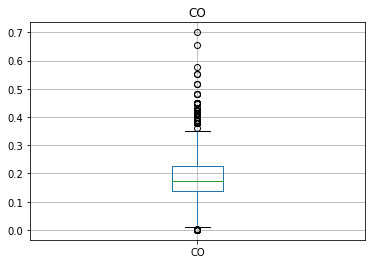

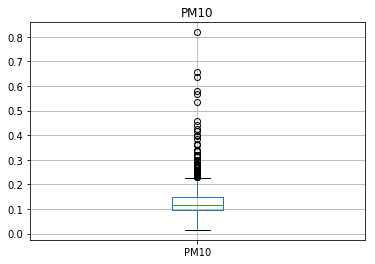

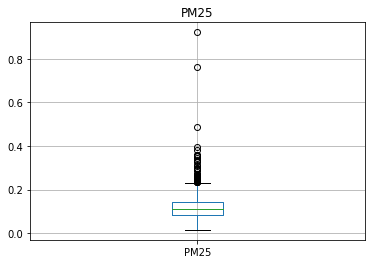

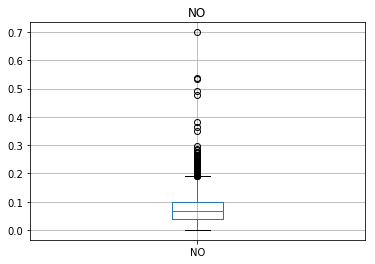

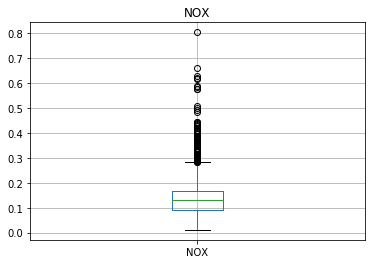

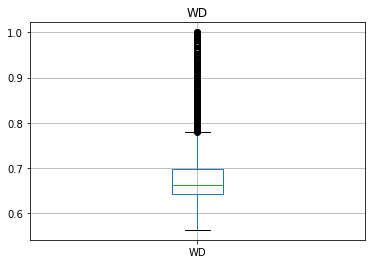

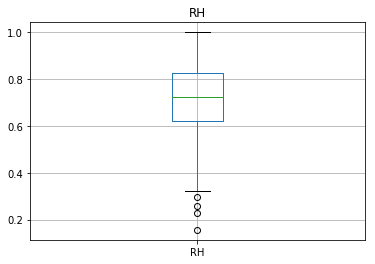

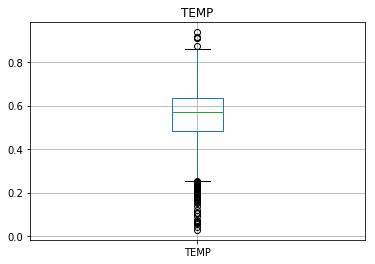

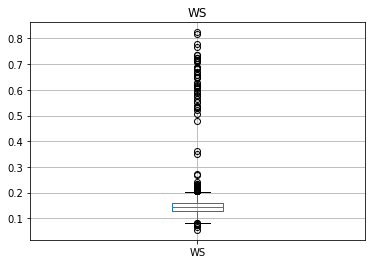

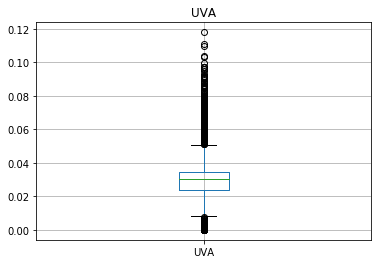

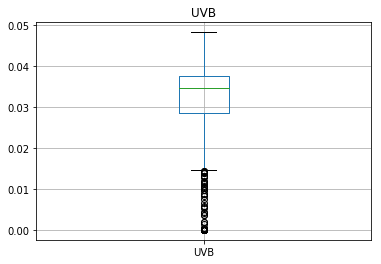

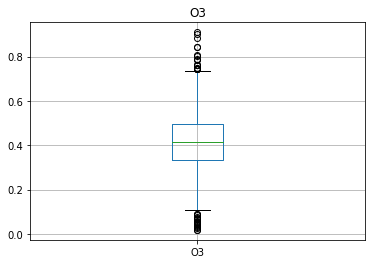

In [327]:
import matplotlib.pyplot as plt
df[["CO"]].boxplot()
plt.title("CO")
plt.show()
df[["PM10"]].boxplot()
plt.title("PM10")
plt.show()
df[["PM25"]].boxplot()
plt.title("PM25")
plt.show()
df[["NO"]].boxplot()
plt.title("NO")
plt.show()
df[["NOX"]].boxplot()
plt.title("NOX")
plt.show()
df[["WD"]].boxplot()
plt.title("WD")
plt.show()
df[["RH"]].boxplot()
plt.title("RH")
plt.show()
df[["TEMP"]].boxplot()
plt.title("TEMP")
plt.show()
df[["WS"]].boxplot()
plt.title("WS")
plt.show()
df[["UVA"]].boxplot()
plt.title("UVA")
plt.show()
df[["UVB"]].boxplot()
plt.title("UVB")
plt.show()
df[["O3"]].boxplot()
plt.title("O3")
plt.show()

Pese a haber eliminado los outliers que se detectaron gráficamente, los datos aún están distribuidos heterogéneamente.  

In [339]:
X = df.values[:,-1:]

In [341]:
df.head()

,registered_on,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
0,2003-12-14,0.172413,0.094241,0.052434,0.016015,0.033293,0.643926,0.670000,0.415679,0.156788,0.035060,0.036334,0.359281
1,2003-12-15,0.241378,0.160995,0.119850,0.084537,0.111707,0.618166,0.822219,0.501561,0.155087,0.034838,0.036579,0.359281
2,2003-12-16,0.344828,0.227749,0.123596,0.118929,0.174259,0.626491,0.504444,0.694880,0.149334,0.033797,0.038170,0.544910
3,2003-12-17,0.275862,0.166230,0.138577,0.103177,0.170368,0.649371,0.503333,0.734857,0.167239,0.027892,0.026847,0.586826
4,2003-12-18,0.344828,0.172775,0.183521,0.119716,0.182938,0.624373,0.654444,0.611180,0.175061,0.032705,0.034957,0.610778


In [342]:
from sklearn.preprocessing import StandardScaler

In [343]:
scaler=StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

C:\Users\Matu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [250]:
X_train=X[0:1200]
X_test=X[1200:]

In [345]:
X_train

array([[-0.4483497523180856],
       [-0.4483497523180856],
       [1.0243742093523367],
       ...,
       [-0.2785304273701147],
       [-0.42380752010521655],
       [-0.6771302936799001]], dtype=object)

#### b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción para el tiempo siguiente usando los valores de los últimos perı́odos de tiempo. El número de perı́odos de tiempos "hacia atrás" que usaremos se denomina *lag*. Por ejemplo, tendremos un *lag* igual a 3, si para predecir el valor $x_{t+1}$ en el tiempo siguiente usamos la información del tiempo actual $x_t$ y la de los dos perı́odos anteriores $x_{t-1}$ y $x_{t-2}$ como variables de entrada. Realice una función que reciba una secuencia de valores y la transforme en dos arreglos *dataX* (inputs) y *dataY* (targets), además utilicela para generar los conjuntos de entrenamiento y test para el problema decidiendo el valor del *lag*.

In [346]:
def create_dataset(dataset,lag=1):
    dataX=list()
    dataY=list()
    largo=len(dataset);
    rango=largo-lag;
    for i in range(rango):
        aux=list();
        for j in range(lag):
            aux.append(dataset[i+j]);
            if j==(lag-1):
                dataY.append(dataset[i+j+1]);
        dataX.append(aux);
    return np.array(dataX),np.array(dataY)

In [347]:
dataset=[20.7,17.9,18.8,14.6,15.8,15.8,10.1] #EJEMPLO DADO

Por ejemplo si en el dataset tenemos el arreglo 20.7,17.9,18.8,14.6,15.8,15.8,10.1.

In [348]:
XX,YY = create_dataset(dataset,3)

In [349]:
print(XX,YY)

[[20.7 17.9 18.8]
 [17.9 18.8 14.6]
 [18.8 14.6 15.8]
 [14.6 15.8 15.8]] [14.6 15.8 15.8 10.1]


La función debiese generar $(X_1,X_2,X_3)$ e $Y$:


|$X_0$|$X_1$|$X_2$|Y|
|---|---|---|---|
|20.7|17.9|18.8|14.6|
|17.9|18.8|14.6|15.8|
|18.8|14.6|15.8|15.8|
|14.6|15.8|15.8|10.1|



Se crean los conjuntos de entrenamiento y pruebas.  

In [438]:
lag = 3
trainX, trainY = create_dataset(X_train.flatten(), lag)
testX, testY = create_dataset(X_test.flatten(), lag)

In [351]:
trainX

array([[-0.44834975, -0.44834975,  1.02437421],
       [-0.44834975,  1.02437421,  1.35692478],
       [ 1.02437421,  1.35692478,  1.54695368],
       ...,
       [-0.52066525,  0.71987665,  1.36808898],
       [ 0.71987665,  1.36808898, -0.27853043],
       [ 1.36808898, -0.27853043, -0.42380752]])

#### c) En estos momentos tenemos nuestros datos en la forma [*samples, features*]. Sin embargo, la red RNN necesita que los datos se encuentren en un arreglo de tres dimensiones [*samples, time steps, features*]. Transforme el  conjuntos de entrenamiento y de pruebas a la estructura deseada, incorporando el *lag* como *features*. Defina dos modelos para comparar, una red recurrente simple y una red convolucional unidimensional (donde el kernel es un vector de largo $w$), comente sobre las dimensiones/*shape* de los parámetros de cada una de las redes. Entrene los dos modelos con la nueva representación ¿Qué limitaciones tiene el tamaño/*width* del kernel de la convolucional?.

El tamaño del kernel debe ser tal que permita recorrer el input, en este caso, necesariamente debe ser 1.  

In [364]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [353]:
trainX.shape

(1197, 1, 3)

In [354]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Conv1D, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [355]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=4, input_shape=(1,lag), activation='tanh',return_sequences=False,go_backwards=False))
model_rnn.add(Dense(1,activation='linear'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()
rnn_weights = model_rnn.get_weights()
model_rnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1197/1197 [==============================] - 3s 2ms/step - loss: 0.8838
Epoch 2/25
1197/1197 [==============================] - 3s 2ms/step - loss: 0.7892
Epoch 3/25
1197/1197 [==============================] - 3s 2ms/step - loss: 0.7859
Epoch 4/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7841
Epoch 5/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7820
Epoch 6/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7791
Epoch 7/25
1197/1197 [======================

In [356]:
model_cnn = Sequential()
model_cnn.add(Conv1D(4, kernel_size=1,input_shape=(1,lag), activation='relu',padding='valid')) 
model_cnn.add(Flatten())
model_cnn.add(Dense(1,activation='linear'))
model_cnn.compile(loss='mean_squared_error', optimizer='adam')
model_cnn.summary()
cnn_weights = model_cnn.get_weights()
model_cnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 1, 4)              16        
_________________________________________________________________
flatten_3 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1197/1197 [==============================] - 3s 3ms/step - loss: 1.1318
Epoch 2/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.8606
Epoch 3/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.8051
Epoch 4/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7898
Epoch 5/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.

#### d) Mida desempeño de los dos modelos a través del *root mean square error* (RMSE) y compare. Para ésto deberá realizar las predicciones sobre el conjunto de entrenamiento y pruebas/validación, recuerde denormalizar los datos para que el error pueda ser computado en la escala original del rango de valores.

In [365]:
batch_size=32 

trainPredict = model_rnn.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [371]:
testPredict = model_rnn.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [367]:
from sklearn.metrics import mean_squared_error

Recurrente:

In [372]:
from math import * 
trainScore = sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score: '+ str(trainScore) +' RMSE')

testScore = sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score: '+ str(testScore) +' RMSE')

Train Score: 0.11055811948114212 RMSE
Test Score: 0.10214364516415231 RMSE


In [373]:
trainPredict = model_cnn.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = model_cnn.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)

Convolusional:

In [374]:
trainScore = sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score: '+ str(trainScore) +' RMSE')

testScore = sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score: '+ str(testScore) +' RMSE')

Train Score: 0.11012674601526716 RMSE
Test Score: 0.10087993801310824 RMSE


Se observan resultados muy similares en ambas redes neuronales, luego de desnormalizar los datos y comprarlos.  

#### e) Grafique las predicciones del conjunto de entrenamiento y pruebas/validación, y contrástelas con la serie de tiempo original. Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción del modelo, comente.

In [386]:
import matplotlib.pyplot as plt

Para la red Recurrente:

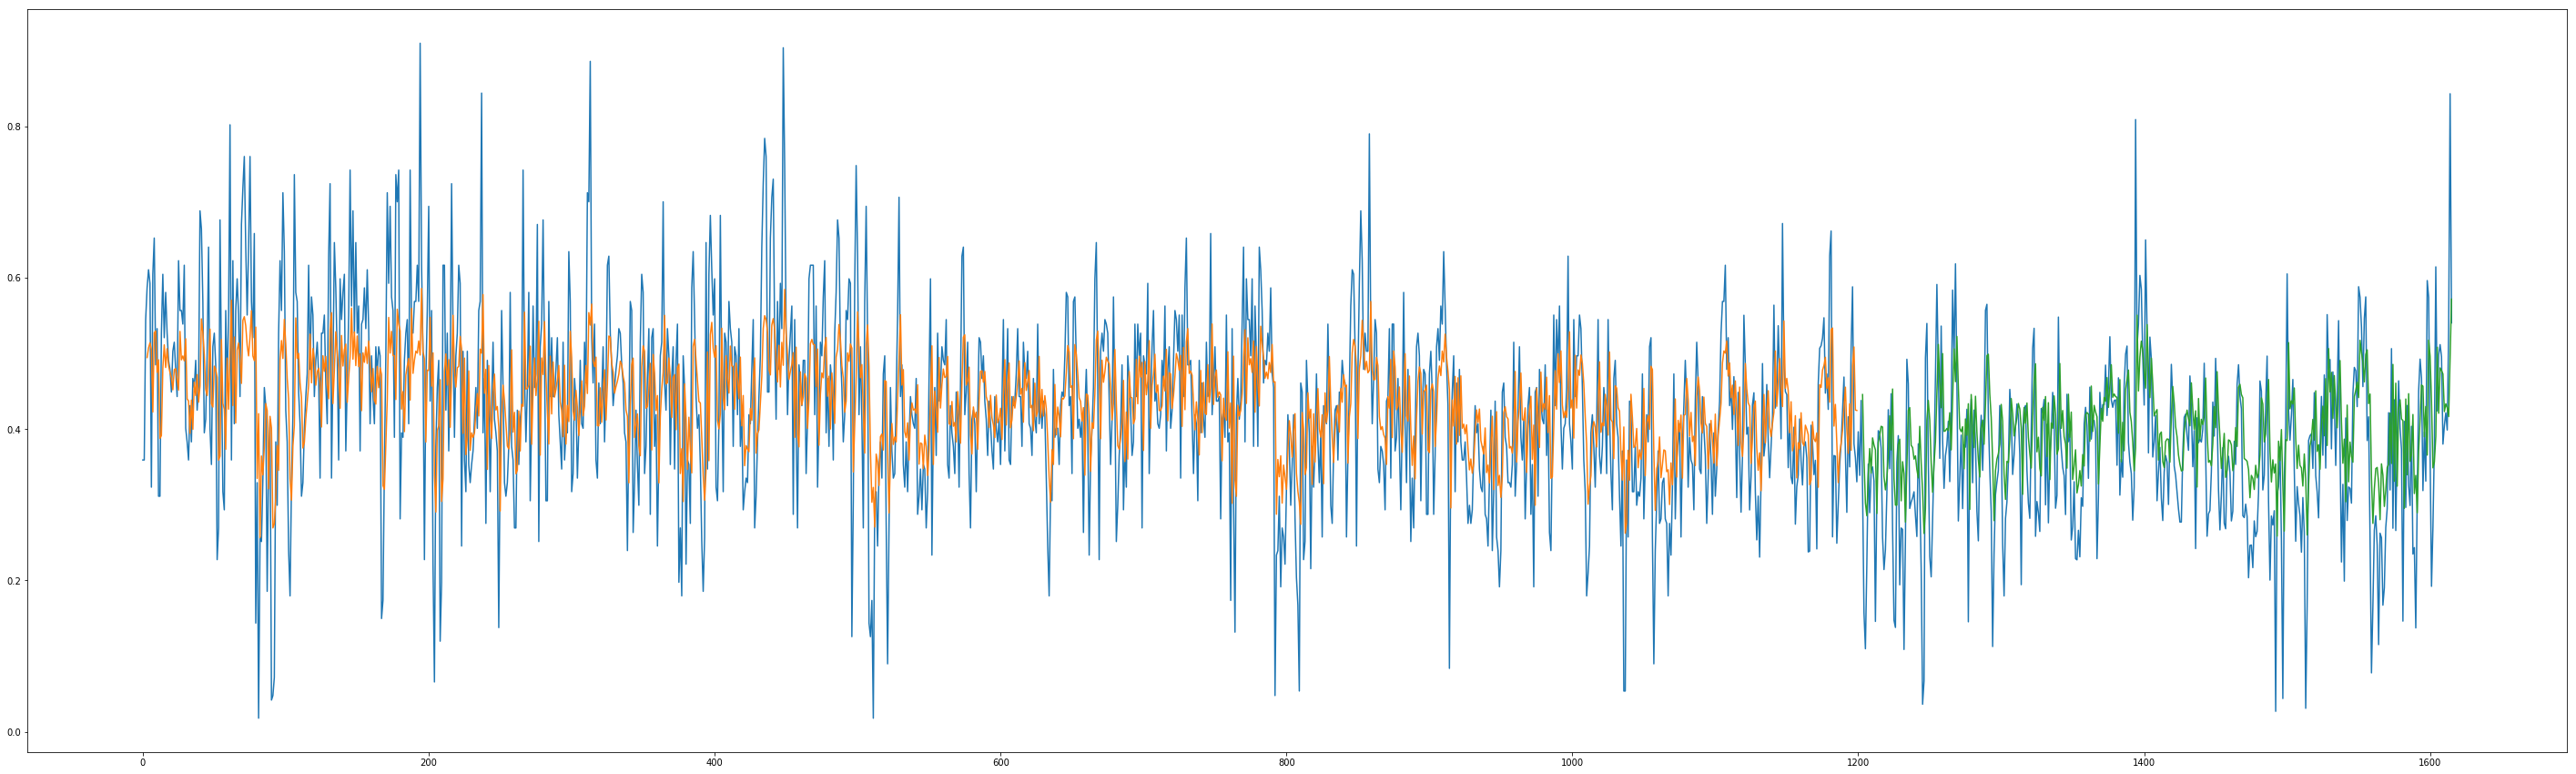

In [424]:
...# shift train predictions for plotting
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
...# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):len(X), :] = testPredict

plt.figure(figsize=(50,15))
plt.plot(X)
plt.plot(trainPredictPlot.flatten())
plt.plot(testPredictPlot.flatten())
plt.show()

Para la red convolusional:  

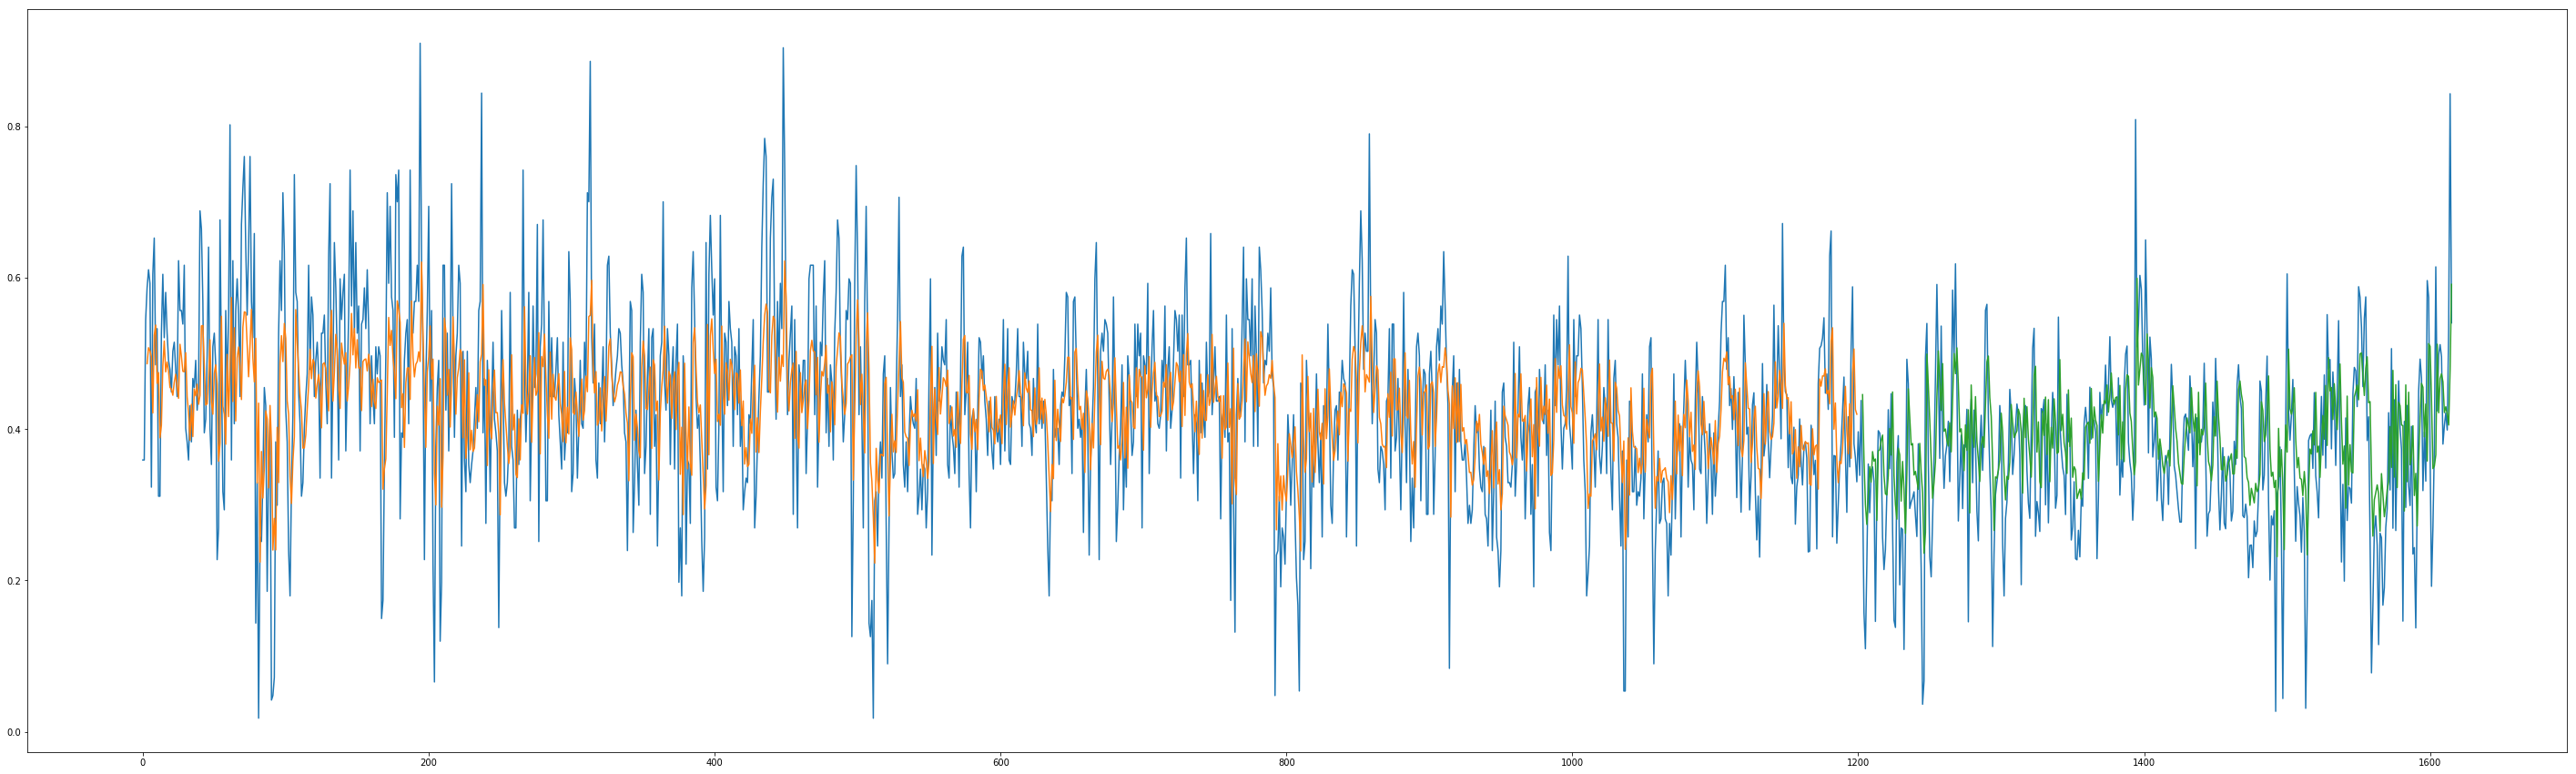

In [420]:
...# shift train predictions for plotting
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
...# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):len(X), :] = testPredict

plt.figure(figsize=(50,15))
plt.plot(X)
plt.plot(trainPredictPlot.flatten())
plt.plot(testPredictPlot.flatten())
plt.show()

Podemos ver que el modelo no realiza un buen trabajo tanto para predecir el conjunto de entrenamiento (naranjo) como el de test (verde) pues en ambos casos los resultados no se acercan o cubren la linea azul (reales) ya que tienden a estar más centrados (menor rango predicho que el rango real).  
Una explicación para este comportamiento puede ser debido al uso de un valor de lag igual a 3, que es muy pequeño, por lo que se intuye que la red está prediciendo a partir de la media.  

####  f) En lugar de aumentar el número de dimensiones como el el paso c), entrene la red con un *timestep=lag* y con dimensión de entrada = 1. Compare y comente sobre el cambio de dimensiones y número de parámetros de las redes ¿Cuál tipo de red tiene más parámetros y porqué? ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cuál es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).

In [439]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

In [440]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=4, input_shape=(lag,1), activation='tanh',return_sequences=False,go_backwards=False))
model_rnn.add(Dense(1,activation='linear'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
model_rnn.summary()

Epoch 1/25
1197/1197 [==============================] - 3s 3ms/step - loss: 0.8737
Epoch 2/25
1197/1197 [==============================] - 3s 2ms/step - loss: 0.7925
Epoch 3/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7887
Epoch 4/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7865
Epoch 5/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7865
Epoch 6/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7844
Epoch 7/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7844
Epoch 8/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7830
Epoch 9/25
1197/1197 [==============================] - 3s 2ms/step - loss: 0.7822
Epoch 10/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7817
Epoch 11/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7815
Epoch 12/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7807
E

In [443]:
model_cnn = Sequential()
model_cnn.add(Conv1D(4, kernel_size=3,input_shape=(lag,1), activation='relu',padding='valid')) # or kernel=2
model_cnn.add(Flatten())
model_cnn.add(Dense(1,activation='linear'))
model_cnn.compile(loss='mean_squared_error', optimizer='adam')
model_cnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
model_cnn.summary()

Epoch 1/25
1197/1197 [==============================] - 3s 2ms/step - loss: 1.0980
Epoch 2/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.8934
Epoch 3/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.8341
Epoch 4/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.8081
Epoch 5/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7922
Epoch 6/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7857
Epoch 7/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7807
Epoch 8/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7781
Epoch 9/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7767
Epoch 10/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7771
Epoch 11/25
1197/1197 [==============================] - 2s 2ms/step - loss: 0.7741
Epoch 12/25
1197/1197 [==============================] - 3s 2ms/step - loss: 0.7756
E

La red que tiene más parámetros es la red recurrente, ya que la convolusional realiza una reducción de los parámetros mediante su capa convolusional. Los tiempos de entrenamiento y los resultados son muy similares, y no se produce una ,mejora en el error de entrenamiento en relación al item e).  

#### g) Compare el desempeño de ambos modelos al variar el *lag* definido en c), recuerde que puede variarlo entre 1 y $T_{max}$. Comente brevemente sobre qué resulta mejor, el tener más información para predecir o si ésto satura la predicción por el efecto del gradiente desvaneciente ¿Ésto ocurre sólo con el modelo recurrente o con el convolucional también? ¿Por qué?

Experimentaremos con un lag igual a 7

In [453]:
lag = 7
trainX, trainY = create_dataset(X_train.flatten(), lag)
testX, testY = create_dataset(X_test.flatten(), lag)

In [454]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [446]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=4, input_shape=(1,lag), activation='tanh',return_sequences=False,go_backwards=False))
model_rnn.add(Dense(1,activation='linear'))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()
rnn_weights = model_rnn.get_weights()
model_rnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 4)                 48        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1193/1193 [==============================] - 3s 3ms/step - loss: 0.9562
Epoch 2/25
1193/1193 [==============================] - 2s 2ms/step - loss: 0.8124
Epoch 3/25
1193/1193 [==============================] - 3s 2ms/step - loss: 0.8014
Epoch 4/25
1193/1193 [==============================] - 2s 2ms/step - loss: 0.7960
Epoch 5/25
1193/1193 [==============================] - 2s 2ms/step - loss: 0.7910
Epoch 6/25
1193/1193 [==============================] - 2s 2ms/step - loss: 0.7830
Epoch 7/25
1193/1193 [======================

In [447]:
batch_size=32 

trainPredict = model_rnn.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [448]:
testPredict = model_rnn.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [449]:
trainScore = sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score: '+ str(trainScore) +' RMSE')

testScore = sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score: '+ str(testScore) +' RMSE')

Train Score: 0.10955772276451212 RMSE
Test Score: 0.09736092408380988 RMSE


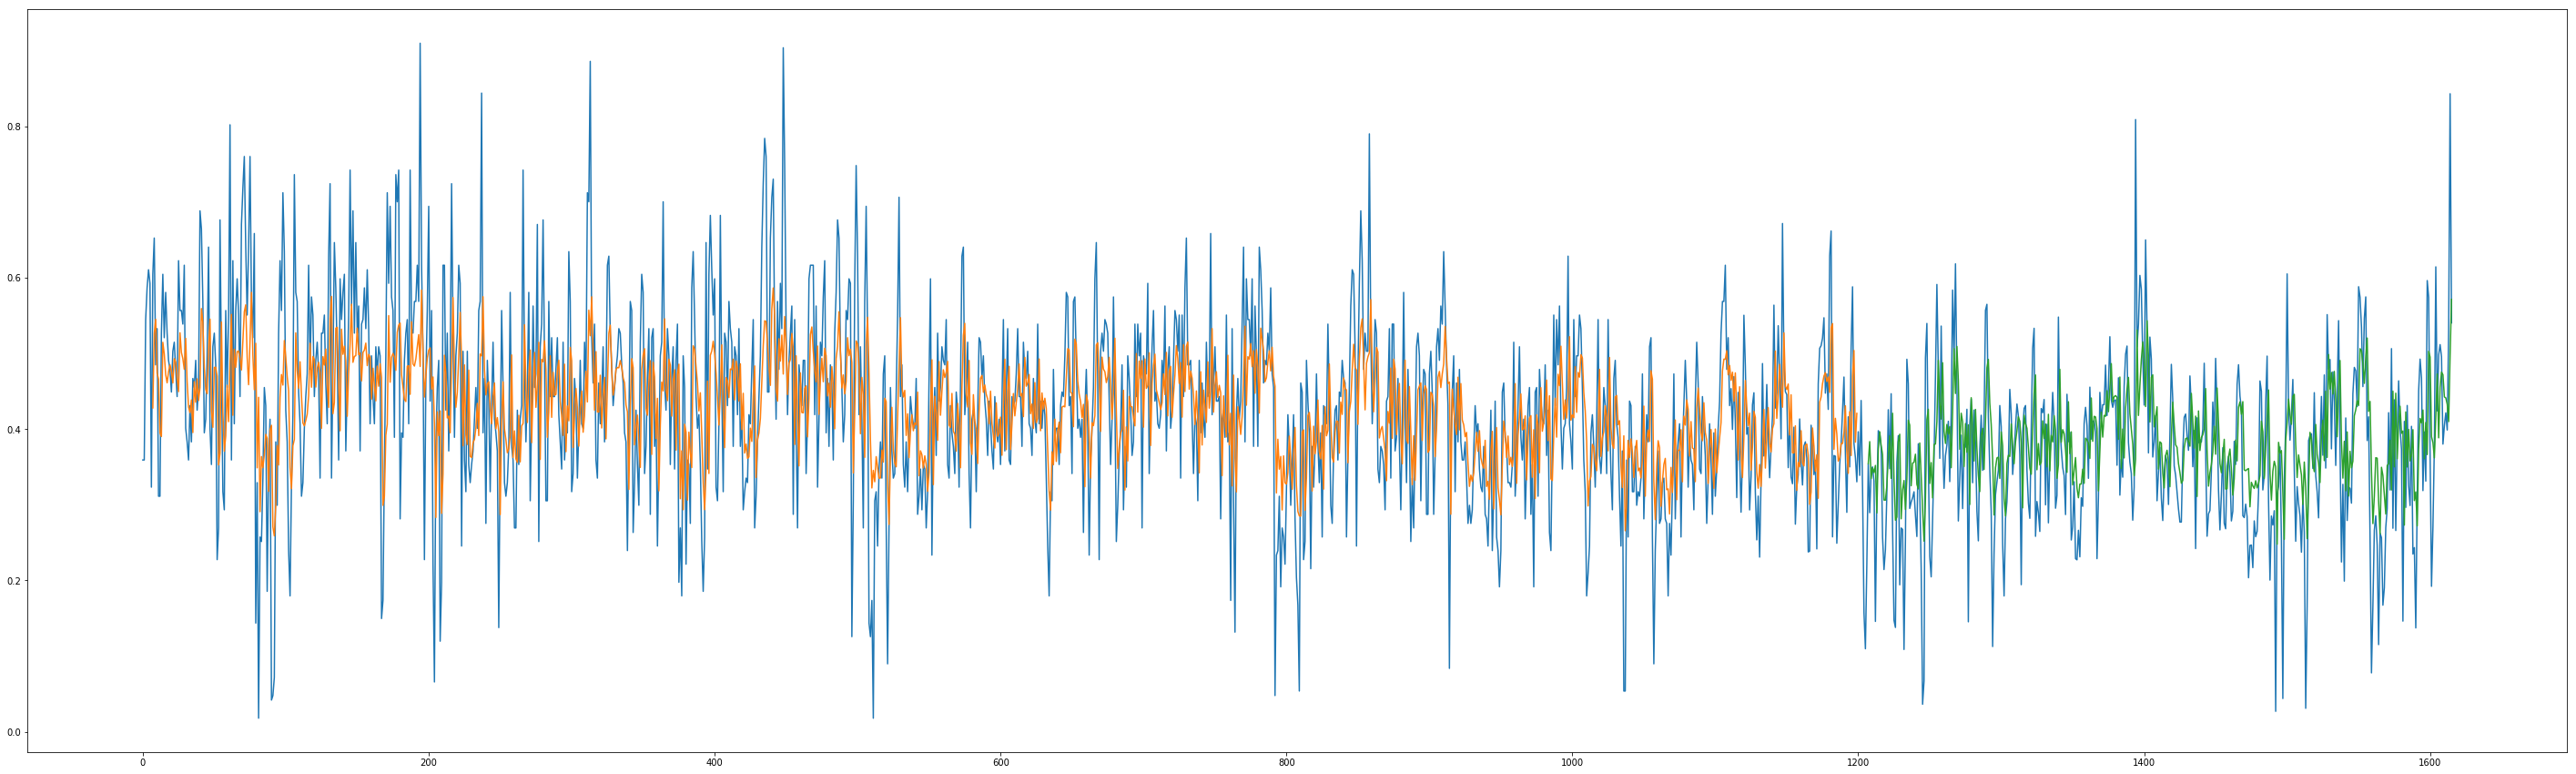

In [450]:
...# shift train predictions for plotting
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
...# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):len(X), :] = testPredict

plt.figure(figsize=(50,15))
plt.plot(X)
plt.plot(trainPredictPlot.flatten())
plt.plot(testPredictPlot.flatten())
plt.show()

In [455]:
model_cnn = Sequential()
model_cnn.add(Conv1D(4, kernel_size=1,input_shape=(1,lag), activation='relu',padding='valid')) 
model_cnn.add(Flatten())
model_cnn.add(Dense(1,activation='linear'))
model_cnn.compile(loss='mean_squared_error', optimizer='adam')
model_cnn.summary()
cnn_weights = model_cnn.get_weights()
model_cnn.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 1, 4)              32        
_________________________________________________________________
flatten_8 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1193/1193 [==============================] - 3s 3ms/step - loss: 1.0630
Epoch 2/25
1193/1193 [==============================] - 3s 2ms/step - loss: 0.8576
Epoch 3/25
1193/1193 [==============================] - 3s 2ms/step - loss: 0.8234
Epoch 4/25
1193/1193 [==============================] - 2s 2ms/step - loss: 0.8077
Epoch 5/25
1193/1193 [==============================] - 3s 2ms/step - loss: 0.

In [456]:
trainPredict = model_cnn.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = model_cnn.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)

In [457]:
trainScore = sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Train Score: '+ str(trainScore) +' RMSE')

testScore = sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score: '+ str(testScore) +' RMSE')

Train Score: 1.012312588660543 RMSE
Test Score: 1.1680008005673526 RMSE


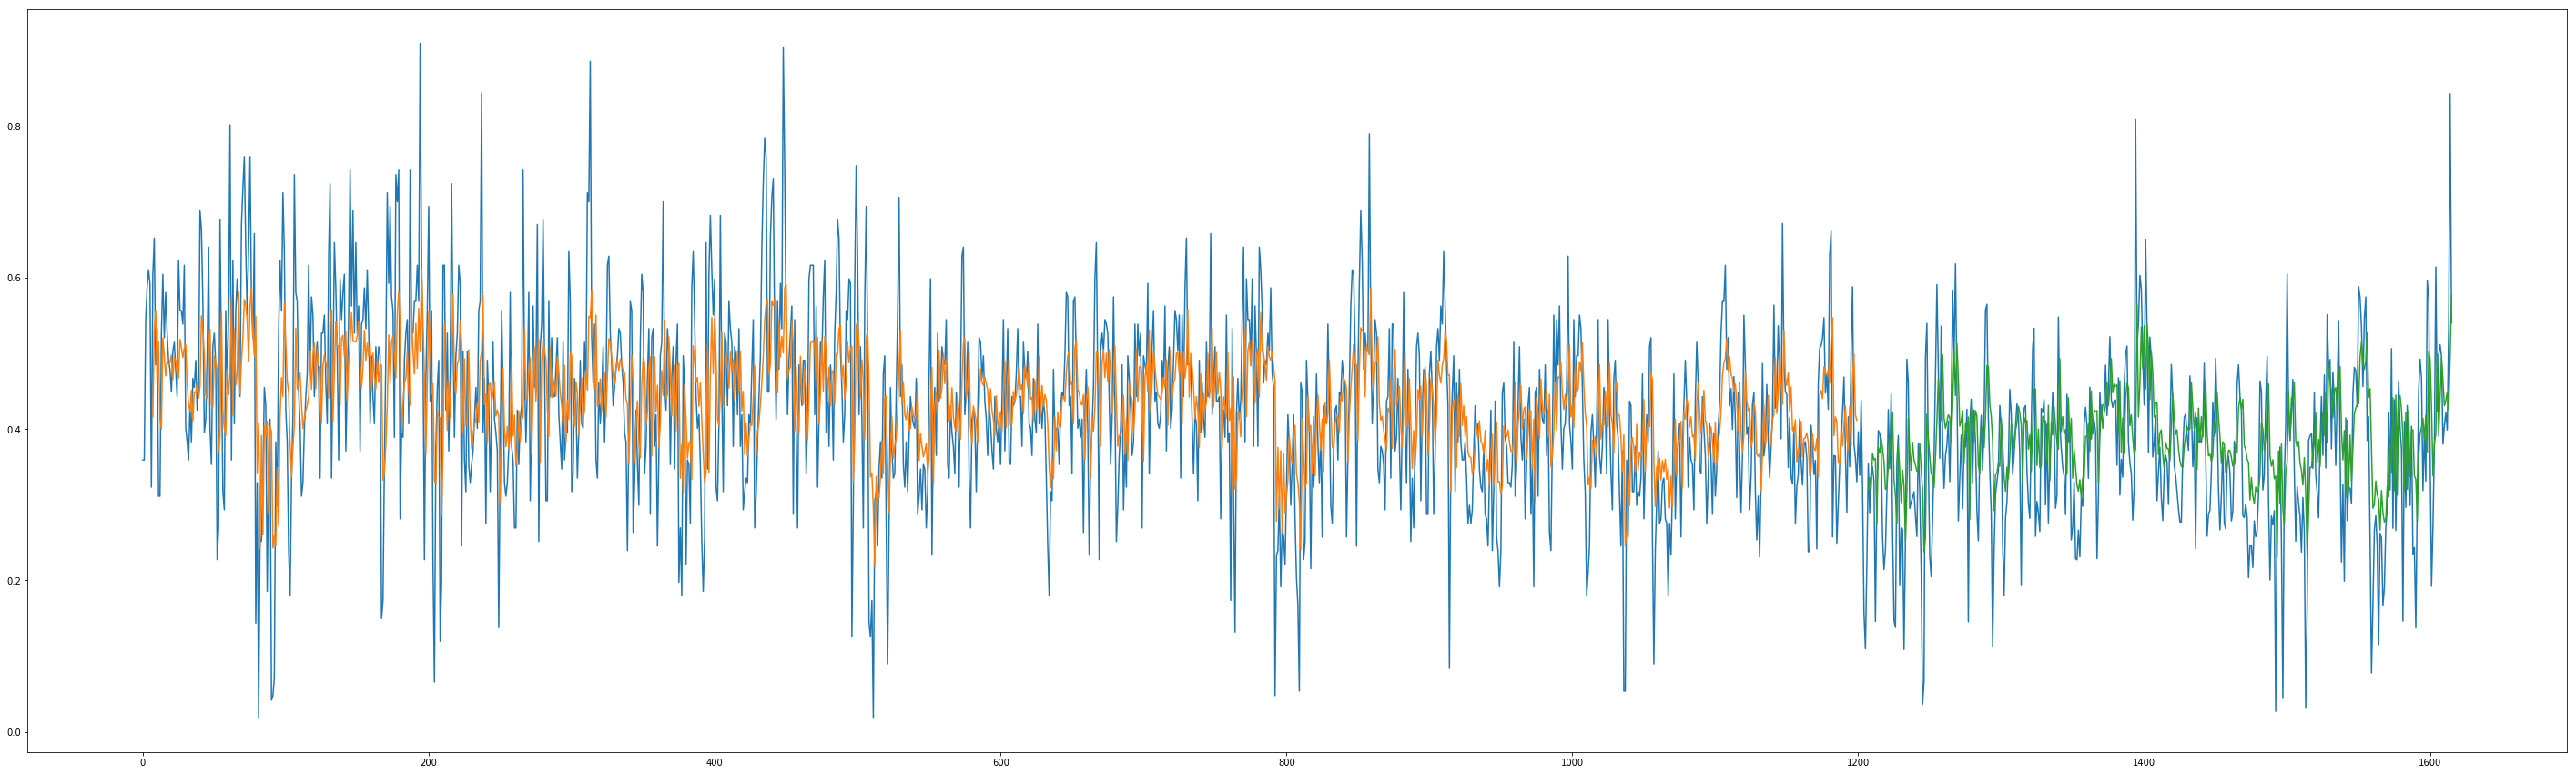

In [458]:
...# shift train predictions for plotting
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
...# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):len(X), :] = testPredict

plt.figure(figsize=(50,15))
plt.plot(X)
plt.plot(trainPredictPlot.flatten())
plt.plot(testPredictPlot.flatten())
plt.show()

Pese a aumentar el valor del lag, no se observaron cambios significativos.  

####  h) Como habrá notado, si usa una ventana de tiempo/*timesteps* muy larga ($T$ grande), las redes tienen dificultades para aprender. Para abordar este problema se le pide experimentar con la siguiente idea: dividir una secuencia de largo $T$ en trozos de largo $K$ y representarla como una matriz de $T/K$ columnas (asumamos que $T$ es un múltiplo de $K$) y $K$ filas, y entrenar la red para procesar la secuencia formada las columnas de esa matriz. De este modo, la red debe aprender dependencias temporales más cortas (largo $T/K$ en vez de $T$), pero accede a toda la información original en forma de atributos ($K$). Llamaremos a esta idea “**time folding**”. Se le recomienda usar un valor de $K$ que tenga sentido en el problema (por ejemplo $K=7$ representaría una semana). Defina y entrene los modelos para ésta nueva representación.  
¿Cómo se ven afectados los modelos?

In [ ]:
model_rnn = ?
model_cnn = ?

#### i) [Opcional] Experimente con variar el número de unidades de la red recurrente (RNN) y el número de filtros de las capas convolucionales. Comente

#### j) [Opcional] Experimente con variar el *width* de los filtros convolucionales ¿Cuál sería el efecto de ésto? ¿Qué limite tiene (mayor y menor)?

#### Agregar otras mediciones como input:  $CO, PM10, NO, NO_x,...,UVB, O_3$



<img src="https://image.slidesharecdn.com/scaled-ml-2018-180529212354/95/role-of-tensors-in-machine-learning-2-638.jpg?cb=1527629345" title="tensors" width="65%"/>

*Decida si continuar con la convolucional 1D o cambiar a convolucional 2D, comente sobre ésta decisión.*

#### k) Agregue las otras mediciones como nuevos valores de entrada al modelo definido en f), por lo que ahora se transforma la serie de tiempo a N-Dimensional, se tiene un *timestep=lag* con un *features*= mediciones nuevas + Ozono. Defina los nuevos modelos con el mejor *lag* encontrado en g).

In [ ]:
...#ejemplo:
new_sequences = np.vstack([co_seq,pm10_seq,...,O3_seq]) # (Contaminantes, dias de verano entre 2003-2016)

#### l) Entrene los modelos  ¿Se observan los mismos resultados? ¿Las mediciones incorporadas como información adicional ayudan al modelo? Comente y compare.

<a id="refs"></a>
## Referencias
[1] Borucki, W. J., Koch, D. G., Basri, G., Batalha, N., Boss, A., Brown, T. M., ... & Dunham, E. W. (2011). *Characteristics of Kepler planetary candidates based on the first data set*. The Astrophysical Journal, 728(2), 117. also in: https://exoplanetarchive.ipac.caltech.edu/index.html  
[2] Bugueno, M., Mena, F., & Araya, M. *Refining Exoplanet Detection Using Supervised Learning and Feature Engineering*.  
[3] Sutskever, I., Martens, J., Dahl, G. E., & Hinton, G. E. (2013). *On the importance of initialization and momentum in deep learning*. ICML (3), 28(1139-1147), 5.  
[4] Lin, T. Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). *Focal loss for dense object detection*. In Proceedings of the IEEE international conference on computer vision (pp. 2980-2988).  
[5] Chen, P., Chen, Y., & Rao, M. (2008). *Metrics defined by Bregman divergences: Part 2*. Communications in Mathematical Sciences, 6(4), 927-948.  
[6] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).   
[7] He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).    
[8] Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). *Dropout: a simple way to prevent neural networks from overfitting*. The Journal of Machine Learning Research, 15(1), 1929-1958.  
[9] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[10] Krizhevsky, A., Nair, V., & Hinton, G. (2014). *The CIFAR-10 dataset*. online: http://www.cs.toronto.edu/kriz/cifar.html , 4.  
[11] Bengio, Y. (2012, June). *Deep learning of representations for unsupervised and transfer learning*. In Proceedings of ICML Workshop on Unsupervised and Transfer Learning (pp. 17-36).  
[12] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.  
[13] Ruder, S. (2017). *An overview of multi-task learning in deep neural networks*. arXiv preprint arXiv:1706.05098.  